In [1]:
# %load /home/glebi/git/experiment-automation/processing_tools.py
import numpy as np
from scipy.optimize import curve_fit
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib
import scienceplots

plt.style.use(['science', 'russian-font'])

matplotlib.rcParams.update({
    'figure.figsize': [10, 4],
    'savefig.facecolor': 'white',
    'figure.dpi': 150.0,
    'font.size': 12.0,
})


In [2]:
import matplotlib.colors as mcolors
from scipy.signal import find_peaks

In [3]:
df = pd.read_csv("data_4.csv", sep="\t")
wl = df["ангстремы"]
cols = df.columns[1:]
colors = ["red", "green", "green", "blue"]

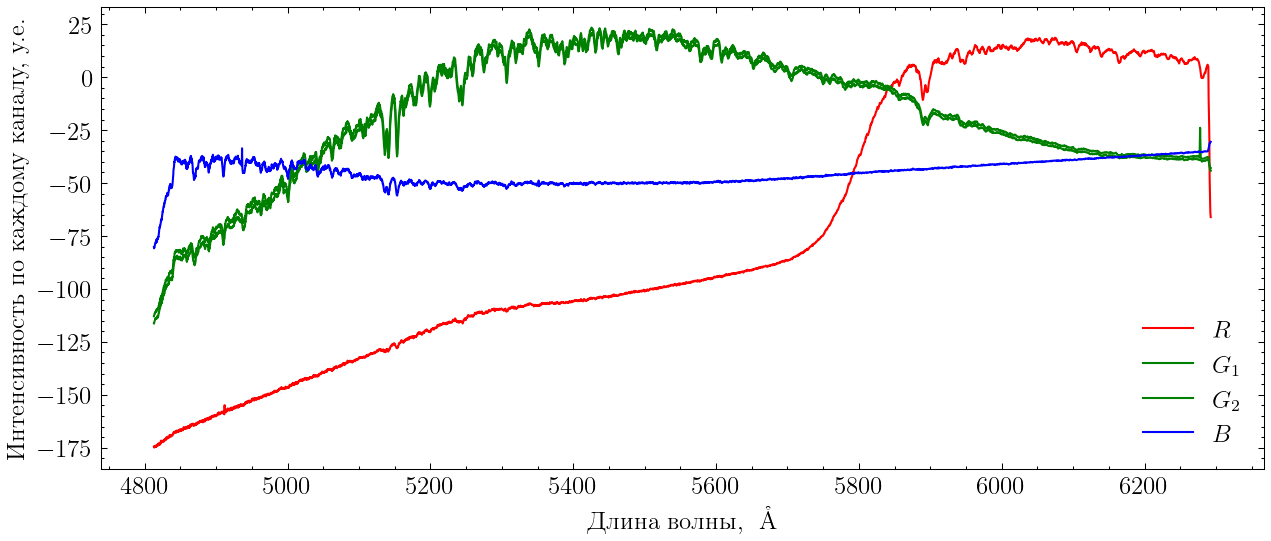

In [4]:
for i, col in enumerate(cols):
    plt.plot(wl, df[col], color = colors[i], label=fr"${col}$")

plt.ylabel("Интенсивность по каждому каналу, у.е.")
plt.xlabel(r"Длина волны, $\textup{~\AA}$")
plt.legend()    

plt.savefig("rggb.png")
plt.show()

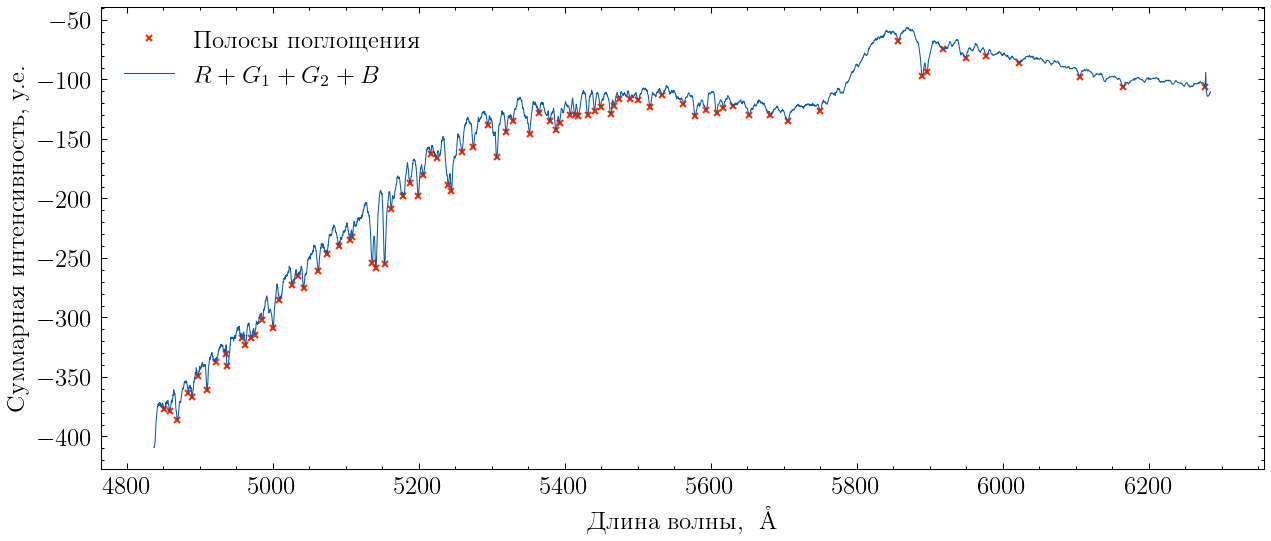

In [5]:
sum_int = df[cols].sum(axis=1)

from_idx = 800
to_idx = -100

y = np.array(sum_int[from_idx:to_idx])
x = np.array(wl[from_idx:to_idx])

peaks, prop = find_peaks(-y, prominence=5, distance=10)
plt.plot(x[peaks], y[peaks], "x", color="C3", markersize=3, label="Полосы поглощения")
plt.plot(x, y, lw=.5, label=r"$R + G_1 + G_2 + B$")

plt.ylabel("Суммарная интенсивность, у.е.")
plt.xlabel(r"Длина волны, $\textup{~\AA}$")
plt.legend()

plt.savefig("sum.png")
plt.show()

In [6]:
def wavelength_to_rgb(wavelength, gamma=0.8):
    ''' taken from http://www.noah.org/wiki/Wavelength_to_RGB_in_Python
    This converts a given wavelength of light to an 
    approximate RGB color value. The wavelength must be given
    in nanometers in the range from 380 nm through 750 nm
    (789 THz through 400 THz).

    Based on code by Dan Bruton
    http://www.physics.sfasu.edu/astro/color/spectra.html
    Additionally alpha value set to 0.5 outside range
    '''
    wavelength = float(wavelength)
    if wavelength >= 380 and wavelength <= 750:
        A = 1.
    else:
        A=0.5
    if wavelength < 380:
        wavelength = 380.
    if wavelength >750:
        wavelength = 750.
    if wavelength >= 380 and wavelength <= 440:
        attenuation = 0.3 + 0.7 * (wavelength - 380) / (440 - 380)
        R = ((-(wavelength - 440) / (440 - 380)) * attenuation) ** gamma
        G = 0.0
        B = (1.0 * attenuation) ** gamma
    elif wavelength >= 440 and wavelength <= 490:
        R = 0.0
        G = ((wavelength - 440) / (490 - 440)) ** gamma
        B = 1.0
    elif wavelength >= 490 and wavelength <= 510:
        R = 0.0
        G = 1.0
        B = (-(wavelength - 510) / (510 - 490)) ** gamma
    elif wavelength >= 510 and wavelength <= 580:
        R = ((wavelength - 510) / (580 - 510)) ** gamma
        G = 1.0
        B = 0.0
    elif wavelength >= 580 and wavelength <= 645:
        R = 1.0
        G = (-(wavelength - 645) / (645 - 580)) ** gamma
        B = 0.0
    elif wavelength >= 645 and wavelength <= 750:
        attenuation = 0.3 + 0.7 * (750 - wavelength) / (750 - 645)
        R = (1.0 * attenuation) ** gamma
        G = 0.0
        B = 0.0
    else:
        R = 0.0
        G = 0.0
        B = 0.0
    return (R,G,B,A)

In [35]:
matplotlib.rcParams.update({
    'figure.figsize': [10, 2],
})

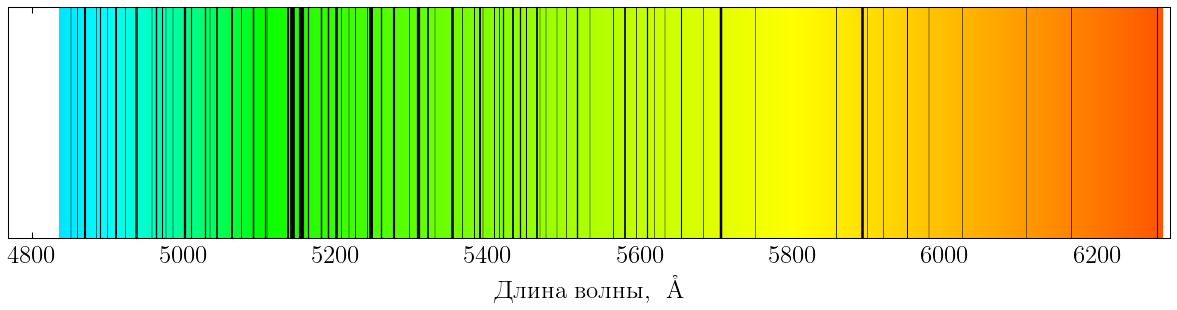

In [36]:
prominences = prop["prominences"]

for lx in np.linspace(x.min(), x.max(), 1000):
    plt.axvline(lx, color=wavelength_to_rgb(lx / 10), lw=1)

for i, peak in enumerate(peaks):
    plt.axvline(x[peak], color='k', lw=prominences[i]/25)

# plt.axis("x")
plt.xlabel(r"Длина волны, $\textup{~\AA}$")
plt.gca().axes.get_yaxis().set_visible(False)

plt.savefig("lines.png")
plt.show()

In [37]:
np.savetxt("peaks.csv", np.vstack((x[peaks], prominences)).T, header="wavelength[A],prominence[c.u.]", comments="", fmt="%.4f", delimiter=",")

### Сопоставление линиям Фраунгофера

In [38]:
df_fh = pd.read_csv("fraunhofer_lines.csv", sep="\t")
fh_arr = np.array(df_fh)

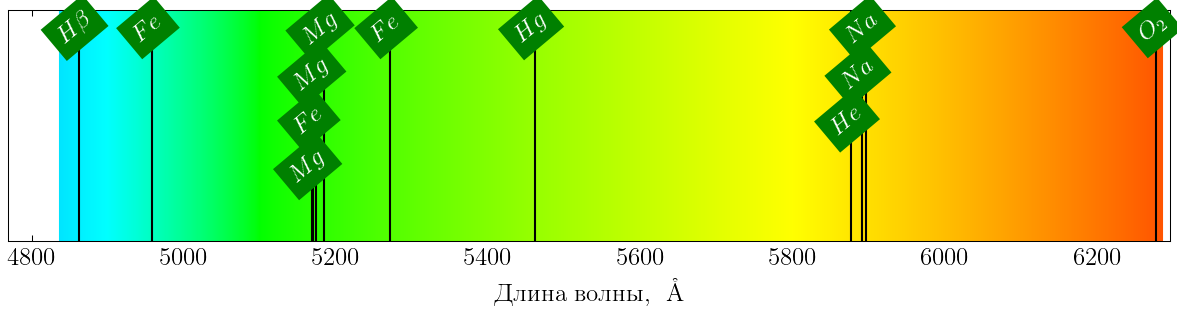

In [41]:
for lx in np.linspace(x.min(), x.max(), 1000):
    plt.axvline(lx, color=wavelength_to_rgb(lx / 10), lw=1)

offset = 0
for (i, fh) in enumerate(fh_arr):
    l = fh[2]*10
    name = fh[1]
    plt.axvline(l, color='k', lw=1)
    
    if (i > 0 and abs(fh[2] - fh_arr[i - 1][2]) < 2):
        offset += 0.2
    else:
        offset = 0

    plt.text(l, 0.9-offset, fr"${name}$",
        size=12, rotation=40,
        horizontalalignment="center", verticalalignment="baseline",
        rotation_mode="anchor", backgroundcolor="g", color="w")

plt.xlabel(r"Длина волны, $\textup{~\AA}$")
plt.gca().axes.get_yaxis().set_visible(False)

plt.savefig("fraunhofer_lines.png")
plt.show()

In [51]:
closer_lines = []

print("name\tdelta\twavelength ")
for fh in fh_arr:
    l = fh[2]*10
    name = fh[1]
    min_idx = 0
    delta = 2000
    for (i, peak) in enumerate(peaks):
        if (abs(x[peak] - l) < delta):
            min_idx = i
            delta = abs(x[peak] - l)
    if (delta < 20):
        closer_lines.append([name, l, min_idx])
    print(f"{name}\t{delta:.2f}\t{l:.2f}")

name	delta	wavelength 
O_2	0.34	6276.61
Na	0.45	5895.92
Na	0.44	5889.95
He	13.89	5875.62
Hg	2.58	5460.73
Fe	4.59	5270.39
Mg	4.47	5183.62
Mg	6.45	5172.70
Fe	6.62	5168.91
Mg	5.04	5167.33
Fe	0.40	4957.61
H\beta	2.22	4861.34


In [52]:
closer_lines

[['O_2', 6276.61, 80],
 ['Na', 5895.92, 73],
 ['Na', 5889.95, 72],
 ['He', 5875.6179999999995, 72],
 ['Hg', 5460.73, 54],
 ['Fe', 5270.389999999999, 38],
 ['Mg', 5183.62, 29],
 ['Mg', 5172.7, 29],
 ['Fe', 5168.91, 28],
 ['Mg', 5167.33, 28],
 ['Fe', 4957.610000000001, 10],
 ['H\\beta', 4861.34, 1]]

In [53]:
matplotlib.rcParams.update({
    'figure.figsize': [10, 4],
})

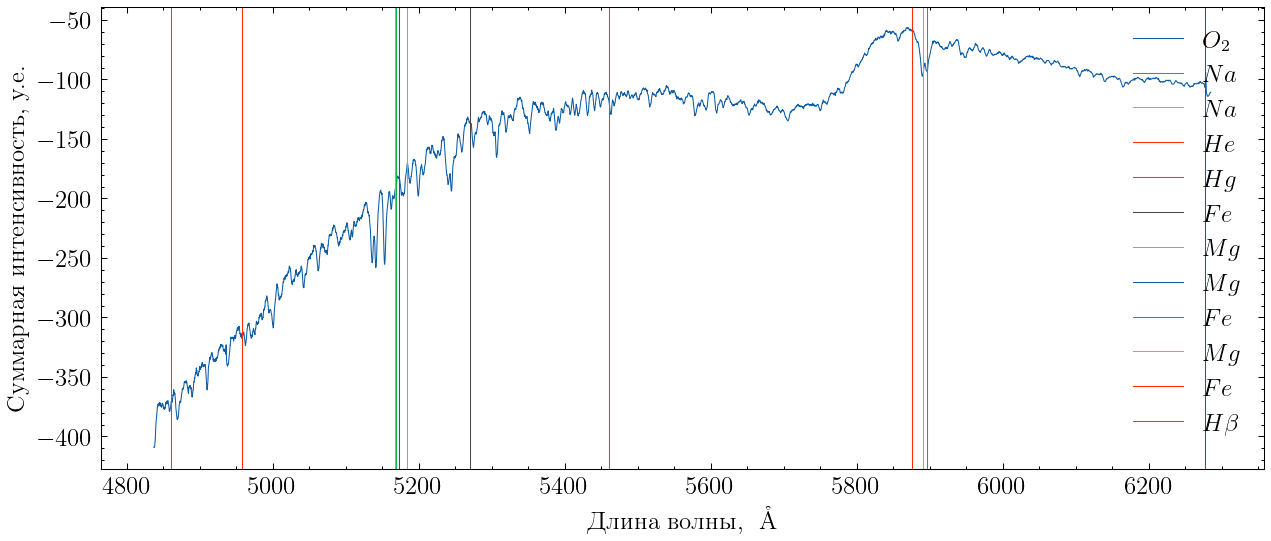

In [54]:
plt.plot(x, y, lw=.5)
for i, closer_line in enumerate(closer_lines):
    plt.axvline(closer_line[1], color=f"C{i}", label=f"${closer_line[0]}$", lw=.5)

plt.ylabel("Суммарная интенсивность, у.е.")
plt.xlabel(r"Длина волны, $\textup{~\AA}$")
plt.legend()

plt.savefig("sum_and_fraunhofer.png")
plt.show()